In [12]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage import filters
from scipy.linalg import lstsq

In [2]:
img1 = cv2.imread("C:/Users/jack_/Downloads/traffic0.png", 0)
img2 = cv2.imread("C:/Users/jack_/Downloads/traffic1.png", 0)

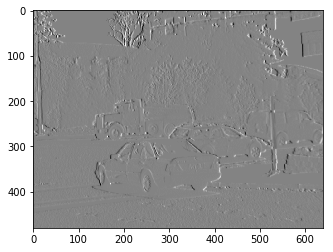

In [3]:
#calculate partial derivatives of test image
deriv_x = filters.sobel_v(traffic0)
deriv_y = filters.sobel_h(traffic0)
plt.imshow(deriv_x, cmap="gray")

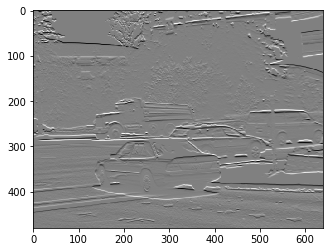

In [4]:
plt.imshow(deriv_y, cmap="gray")

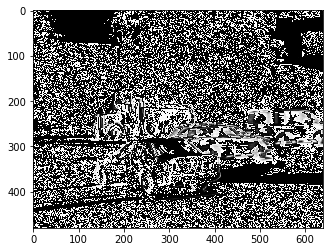

In [5]:
#calculate temporal derivative by taking the difference
#between both images
temporal_deriv = traffic1 - traffic0
plt.imshow(temporal_deriv, cmap="gray")

In [6]:
#find the xy coordinates of neighbors surrounding a given point on a grid of any specified size
#also checks whether the neighborhood of the current coordinates go beyond the boundary of the image
#in which case the specific pixel is skipped
def get_neighbors(p, size, imsize):
    r1 = int((size-1)/2)
    r2 = r1 + 1
    neighbors = []
    x = int(p[0])
    y = int(p[1])
    skip = False
    for i in range(x-r1,x+r2):
        for j in range(y-r1,y+r2):
            if i < 0 or j < 0 or i >= imsize or j >= imsize:
                skip = True
                break
            neighbors.append([i,j])
        if skip:
            break
    return neighbors,skip

In [7]:
#construct a matrix and vector of pixel values at a list of coordinates for two images
#to be used to obtain the matrix of the neighborhood of pixels for both derivative images
#as well as the vector of temporal derivative values for the same neighborhood
def construct_matrix(coords, x, y, t):
    m = []
    v = []
    for c in coords:
        m.append([x[c[0]][c[1]], y[c[0]][c[1]]])
        v.append(t[c[0]][c[1]])
    return m, v

In [13]:
#Lucas-Kanade algorithm
#get the neighbors of a given pixel, construct the matrix and vector with these values
#and calculate the u and v vectors via linear least squares
u = []
v = []
for i in range(deriv_x.shape[0]):
    u_row = []
    v_row = []
    for j in range(deriv_x.shape[1]):
        neighbors, skip = get_neighbors([i,j], 5, deriv_x.shape[0])
        if skip:
            continue
        a, b = construct_matrix(neighbors, deriv_x, deriv_y, -temporal_deriv)
        ls = lstsq(a, b)
        u_row.append(ls[0][0])
        v_row.append(ls[0][1])
    if not u_row:
        continue
    u.append(u_row)
    v.append(v_row)

In [14]:
u = np.asarray(u)
v = np.asarray(v)

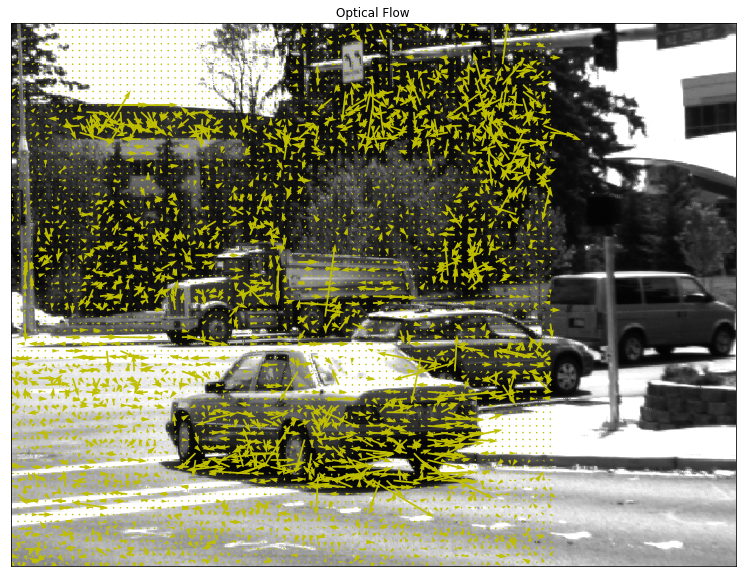

In [16]:
# Subsample the vector field to make it less dense
subsample = 6
rows = u.shape[0]
cols = u.shape[1]
sub_u = u[0:rows:subsample, 0:cols:subsample]
sub_v = v[0:rows:subsample, 0:cols:subsample]
xc = np.linspace(0, cols, sub_u.shape[1])
yc = np.linspace(0, rows, sub_u.shape[0])
# Locations of the vectors
xv, yv = np.meshgrid(xc, yc)
fig1 = plt.figure(figsize = (14,7))
plt.imshow(traffic0,cmap = 'gray')
plt.title('Optical Flow'), plt.xticks([]), plt.yticks([])
# Plot the vectors
plt.quiver(xv, yv, sub_u, sub_v, color='y')